# **E-COMMERCE ANALYSIS: IN SEARCH OF KEY TO RETAINING CUSTOMER LOYALTY**

- By Fauzan Harlyanto Putra

Transaction is common in life, one of the signs that our civilisation has started is from the early process of transaction. In the past we use trade system where one person trade with another using stuffs like crops or dairy products. Transaction usually happpens in market, and with how the technology rapidly moves we know have a digital platform for market which we know them as 'e-commerce'. Due to the popularity of e-commerce, there are numerous marketplaces, offering various benefits to attract customers.

## **Business Problem Understanding**

An E-commerce company is looking for a way to retain the numbers of their customers. Based on their datasets, there are some factors that helps the customers to retain, and there are also some factors that lead the customer away from the e-commerce platform.

## **Goal**

As a Data Scientist, we are going to analyse this dataset and participate in retaining the number of customers by making a model that detects whether the customer are going to churn from the e-commerce or not.

First, let's take a look at our data.

In [128]:
# initial lib
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import missingno
import warnings

warnings.filterwarnings('ignore')

# preprocess
from sklearn.pipeline import Pipeline as sklPipe
from imblearn.pipeline import Pipeline as ImbPipe

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# algos
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, StackingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier

#imbalance learning
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour, ClusterCentroids, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE

# metrics
from sklearn.metrics import recall_score, classification_report

In [53]:
real_data = pd.read_csv('data_ecommerce_customer_churn.csv')
real_data

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
...,...,...,...,...,...,...,...,...,...,...,...
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0
3939,6.0,NaN,4,Mobile,3,Married,10,1,0.0,124.37,1


In [54]:
real_data.count()

Tenure                      3747
WarehouseToHome             3772
NumberOfDeviceRegistered    3941
PreferedOrderCat            3941
SatisfactionScore           3941
MaritalStatus               3941
NumberOfAddress             3941
Complain                    3941
DaySinceLastOrder           3728
CashbackAmount              3941
Churn                       3941
dtype: int64

Our data consists 3941 rows and 11 columns. Each columns represents:

- `Tenure` = Tenure of a customer in the company
- `WarWarehouseToHome` = Distance between the warehouse to the customer’s home
- `NumberOfDeviceRegistered` = Total number of deceives is registered on a particular customer
- `PreferedOrderCat` = Preferred order category of a customer in the last month.
- `SatisfactionScore` = Satisfactory score of a customer on service.
- `MaritalStatus` = Marital status of a customer.
- `NumberOfAddress` = Total number of address of a customer.
- `Complain` = Flag that explains whether a customer has filed a complain in the last month or not (0 = No Complain; 1 = Complain).
- `DaySinceLastOrder` = Number of days since last order by a customer.
- `CashbackAmount` = Average Cashback a customer receive in last month.
- `Churn` = Flag that explains whether a customer churn or not (0 = Not Churn; 1 = Churn).

And each rows represents customer behaviour that leads them to churn or not. To get better understanding let's explore more about our data.

In [55]:
extract_item = []
for column_names in real_data.columns:
    extract_item.append([
        column_names
        ,real_data[column_names].dtype
        ,real_data[column_names].isna().sum()
        ,round(real_data[column_names].isna().sum()/len(real_data)*100, 2)
        ,real_data[column_names].nunique()
        ,real_data[column_names].unique()[:3]
    ])

extracted_item = pd.DataFrame(extract_item, columns='Name, Data Type, Miss Val (Num), Miss Val (%), Unique (Num), Sample of Unique'.split(', '))
extracted_item


,Name,Data Type,Miss Val (Num),Miss Val (%),Unique (Num),Sample of Unique
0,Tenure,float64,194,4.92,36,"[15.0, 7.0, 27.0]"
1,WarehouseToHome,float64,169,4.29,33,"[29.0, 25.0, 13.0]"
2,NumberOfDeviceRegistered,int64,0,0.00,6,"[4, 3, 6]"
3,PreferedOrderCat,object,0,0.00,6,"[Laptop & Accessory, Mobile, Fashion]"
4,SatisfactionScore,int64,0,0.00,5,"[3, 1, 4]"
5,MaritalStatus,object,0,0.00,3,"[Single, Married, Divorced]"
6,NumberOfAddress,int64,0,0.00,14,"[2, 5, 7]"
7,Complain,int64,0,0.00,2,"[0, 1]"
8,DaySinceLastOrder,float64,213,5.40,22,"[7.0, nan, 8.0]"
9,CashbackAmount,float64,0,0.00,2335,"[143.32, 129.29, 168.54]"


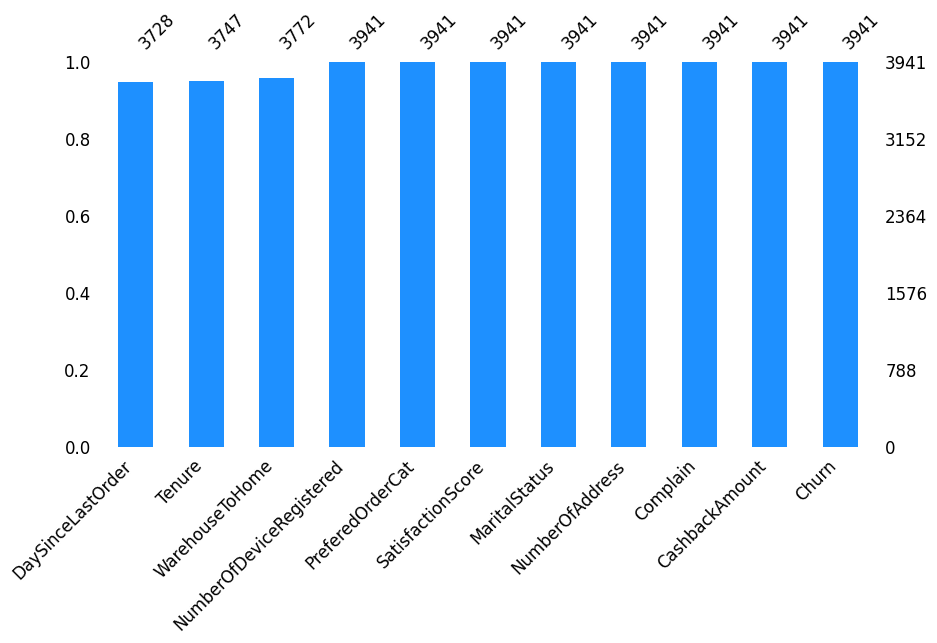

In [56]:
missingno.bar(real_data,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

In here we can see that `Tenure`, `WareHouseToHome`, and `DaySinceLastOrder` columns have missing values.  . We can also see that `PreferedOrderCat` and `MaritalStatus` column are both categorical. Their number of unique feature is also relatively low, so for the future treatment, we are going to use OneHot Encoder for them.

In [57]:
real_data[['Churn']].value_counts()

Churn
0        3267
1         674
Name: count, dtype: int64

In [58]:
real_data['Churn'].value_counts()/len(real_data) * 100

Churn
0    82.897742
1    17.102258
Name: count, dtype: float64

If we look at the values of Churn, we can see that most people in this data are not churning, and 17% of the rest does churn.

In [59]:
real_data[['MaritalStatus']].value_counts()

MaritalStatus
Married          2055
Single           1310
Divorced          576
Name: count, dtype: int64

We can also see the customers martial status, as we can see here that most customers are married, followed by single customers and the last one is divorced customer. This might be useful for the data or no. For the correlation of the columns to our target will be written down later.

In [60]:
real_data[['PreferedOrderCat']].value_counts()

PreferedOrderCat  
Laptop & Accessory    1458
Mobile Phone           887
Fashion                585
Mobile                 559
Grocery                273
Others                 179
Name: count, dtype: int64

Most customer in the last month prefered to order Laptop & Accessory, followed by Mobile Phone, Fashion, Mobile, Grocery, and Others.

In [61]:
real_data[['Complain']].value_counts()

Complain
0           2828
1           1113
Name: count, dtype: int64

Complain seems to correlate with churn, as we can see that most people didn't file a complain and most people churns, but we will see about this correlation later.

In [62]:
real_data[['SatisfactionScore']].value_counts()

SatisfactionScore
3                    1190
1                     805
5                     796
4                     758
2                     392
Name: count, dtype: int64

Despite the majoritty of customer didn't churn last month, we still have a satisfaction score of 3 the most. Does it make SatisfactionScore not correlated to churn?

In [63]:
real_data[['NumberOfDeviceRegistered']].value_counts()

NumberOfDeviceRegistered
4                           1694
3                           1193
5                            591
2                            192
1                            164
6                            107
Name: count, dtype: int64

Our customer in the last month, mostly have 4 and 3 devices registered in Copi E-commerce

## **Data Cleaning & Feature Engineering**

Let's understand our data more by looking back at our dataset description

In [64]:
extract_item = []
for column_names in real_data.columns:
    extract_item.append([
        column_names
        ,real_data[column_names].dtype
        ,real_data[column_names].isna().sum()
        ,round(real_data[column_names].isna().sum()/len(real_data)*100, 2)
        ,real_data[column_names].nunique()
        ,real_data[column_names].unique()[:3]
    ])

extracted_item = pd.DataFrame(extract_item, columns='Name, Data Type, Miss Val (Num), Miss Val (%), Unique (Num), Sample of Unique'.split(', '))
extracted_item

,Name,Data Type,Miss Val (Num),Miss Val (%),Unique (Num),Sample of Unique
0,Tenure,float64,194,4.92,36,"[15.0, 7.0, 27.0]"
1,WarehouseToHome,float64,169,4.29,33,"[29.0, 25.0, 13.0]"
2,NumberOfDeviceRegistered,int64,0,0.00,6,"[4, 3, 6]"
3,PreferedOrderCat,object,0,0.00,6,"[Laptop & Accessory, Mobile, Fashion]"
4,SatisfactionScore,int64,0,0.00,5,"[3, 1, 4]"
5,MaritalStatus,object,0,0.00,3,"[Single, Married, Divorced]"
6,NumberOfAddress,int64,0,0.00,14,"[2, 5, 7]"
7,Complain,int64,0,0.00,2,"[0, 1]"
8,DaySinceLastOrder,float64,213,5.40,22,"[7.0, nan, 8.0]"
9,CashbackAmount,float64,0,0.00,2335,"[143.32, 129.29, 168.54]"


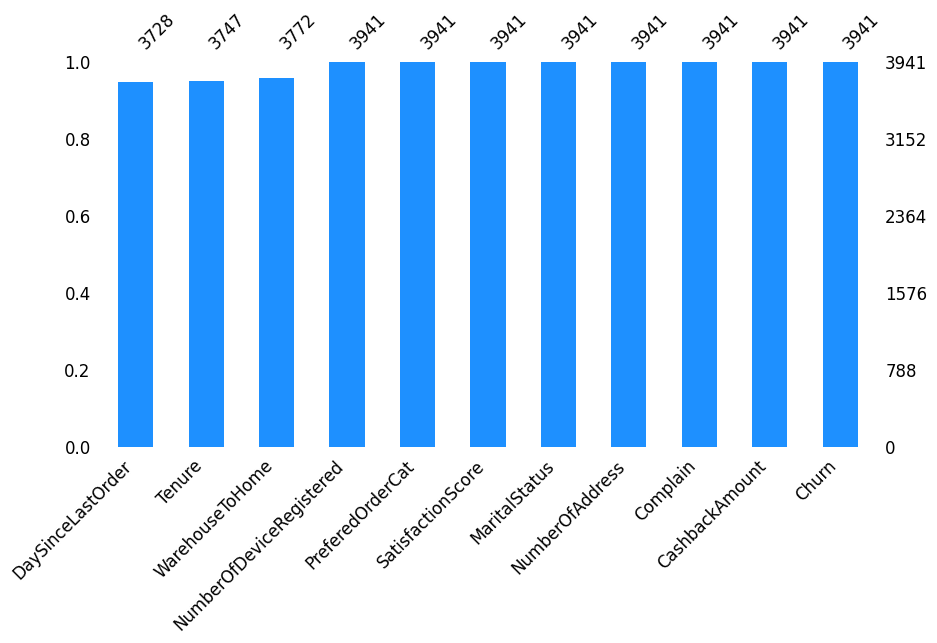

In [65]:
missingno.bar(real_data,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

As we can see, we have a few columns with missing values: `Tenure`, `WarehouseToHome`, and `DaySinceLastOrder`.

Difference:
- Tenure -> 3941 - 3747 = 194 data
- WarehouseToHome -> 3941 - 3772 = 169 data
- DaySinceLastOrder -> 3941 - 3728 = 213 data

This missing values could damage the result of the algorithm. Therefore we have to do a treatment to this missing values, but we have to get to know first, whether this missing values correlate to another column or not.


We will plot heatmap thatshows correlation of missing values to any columns that has missing values too.

The correlation range spans from -1 to 1 which are:
- -1 = Negative Correlation which shows that if there is a variable then there won't be any other variable.
- 0 = No Correlation that shows whether the variable correlates with other column.
- 1 = Positive Correlatioon that shos if there is a variable, then another value has to be exist

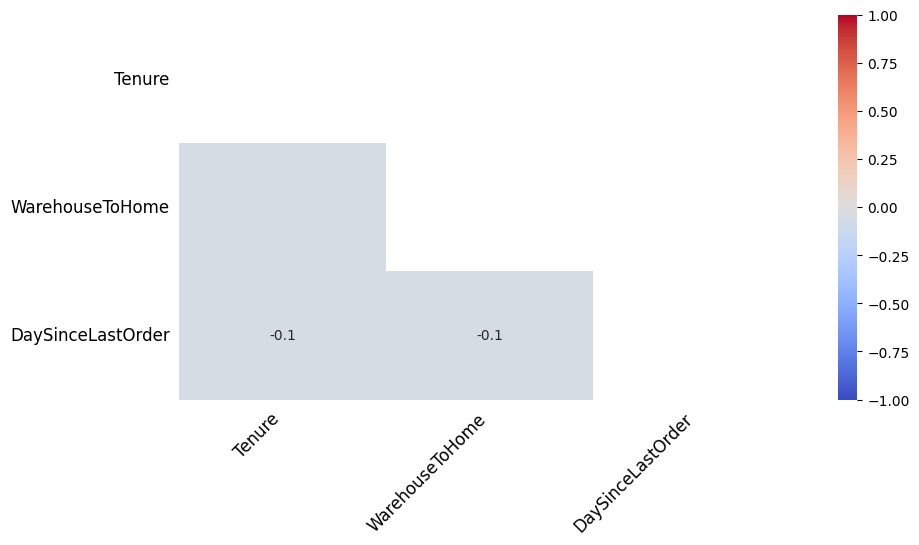

In [66]:
missingno.heatmap(real_data, cmap='coolwarm', figsize=(10,5), fontsize=12);

We can see from the heatmap above that missing values in our table is not correlated to other column. Hence, we can directly drop it.

In [67]:
real_data = real_data.dropna()

display(real_data.head(5), real_data.tail(5))

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
5,7.0,16.0,4,Mobile Phone,2,Divorced,2,0,11.0,152.81,0


,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
3935,26.0,7.0,4,Grocery,1,Married,4,0,9.0,295.99,0
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0
3940,2.0,7.0,3,Laptop & Accessory,5,Married,1,0,2.0,153.73,0


Now that we have dropped the row that has missing values let's see how much row of data do we have

In [68]:
real_data.count()

Tenure                      3365
WarehouseToHome             3365
NumberOfDeviceRegistered    3365
PreferedOrderCat            3365
SatisfactionScore           3365
MaritalStatus               3365
NumberOfAddress             3365
Complain                    3365
DaySinceLastOrder           3365
CashbackAmount              3365
Churn                       3365
dtype: int64

Now we have 3365 data, let's see how is the distribution of each column

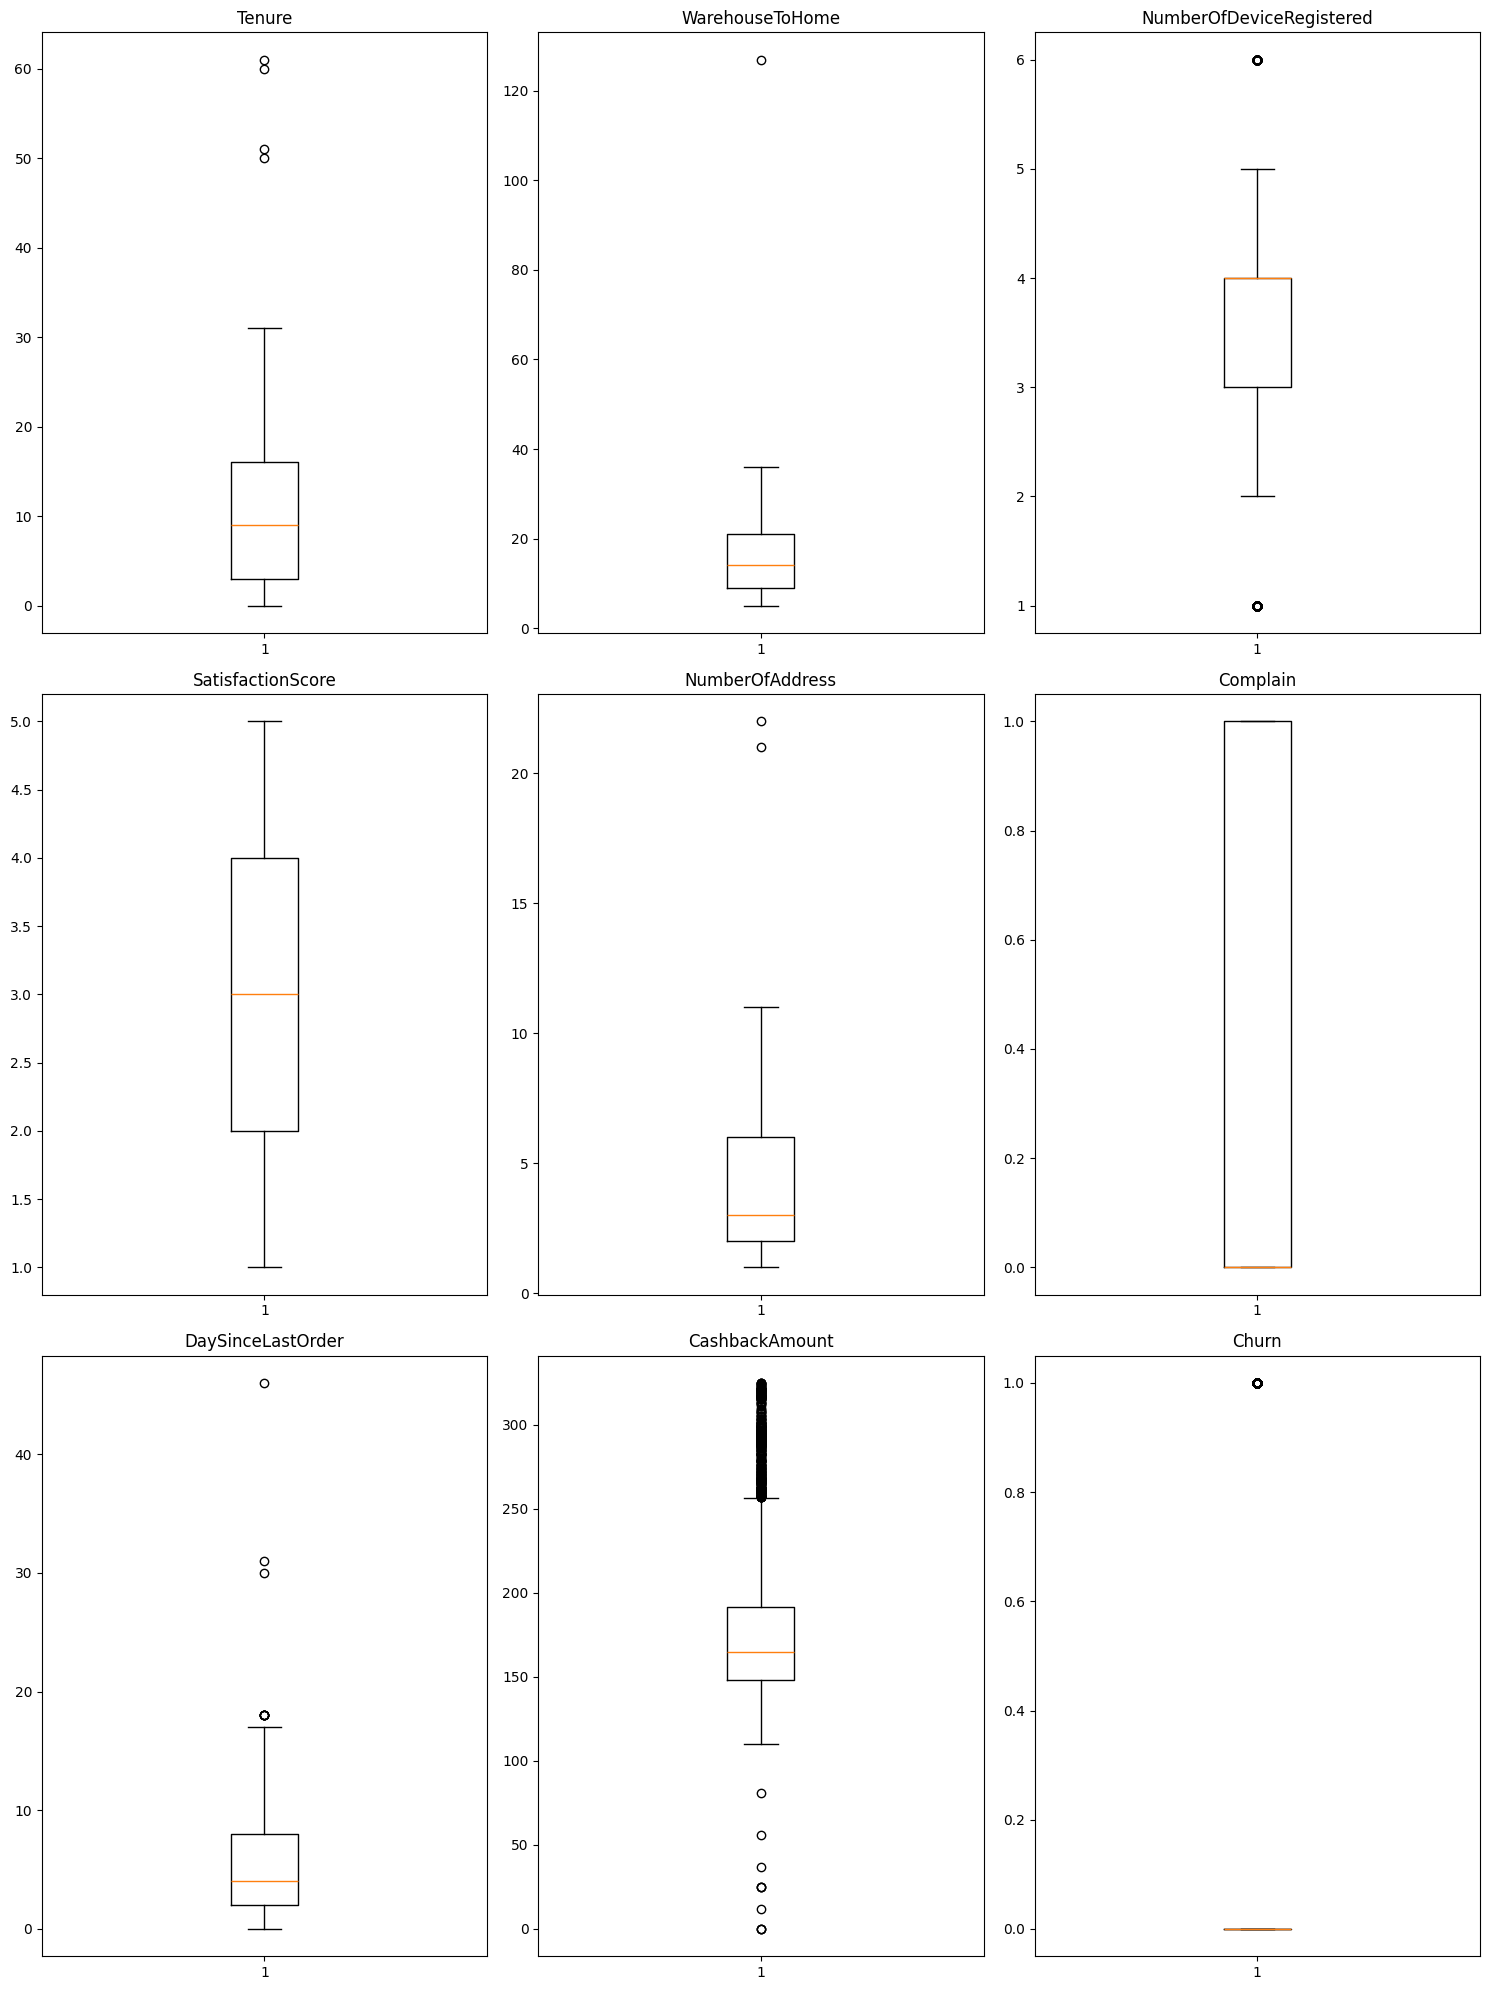

In [69]:
check_data_numerical_columns = real_data.select_dtypes(include=['float64', 'int64']).columns
subplot_cols = len(check_data_numerical_columns)
subplot_rows = (subplot_cols // 3 ) + (subplot_cols % 3 > 0 )

plt.figure(figsize=(15,20))

for i, column in enumerate(check_data_numerical_columns, 1):
    plt.subplot(subplot_rows, 3, i)
    plt.boxplot(real_data[column])
    plt.title(column)

plt.tight_layout()
plt.show()

We can see from those boxplots, columns like `Tenure`, `WarehouseToHome`, `NumberOfAddress`, `DaySinceLastOrder` have very extreme outliers. We can treat this by take them off of our dataset 

In [70]:
# Handling Extreme Outliers

real_data = real_data[~((real_data['Tenure'] > 40) |
                        (real_data['WarehouseToHome'] > 60 ) |
                        (real_data['NumberOfAddress'] > 15) |
                        (real_data['DaySinceLastOrder']> 20)
                        )]
real_data

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
5,7.0,16.0,4,Mobile Phone,2,Divorced,2,0,11.0,152.81,0
...,...,...,...,...,...,...,...,...,...,...,...
3935,26.0,7.0,4,Grocery,1,Married,4,0,9.0,295.99,0
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0


Now that the extreme outliers has been taken off, we can see how the data distribution of each columns

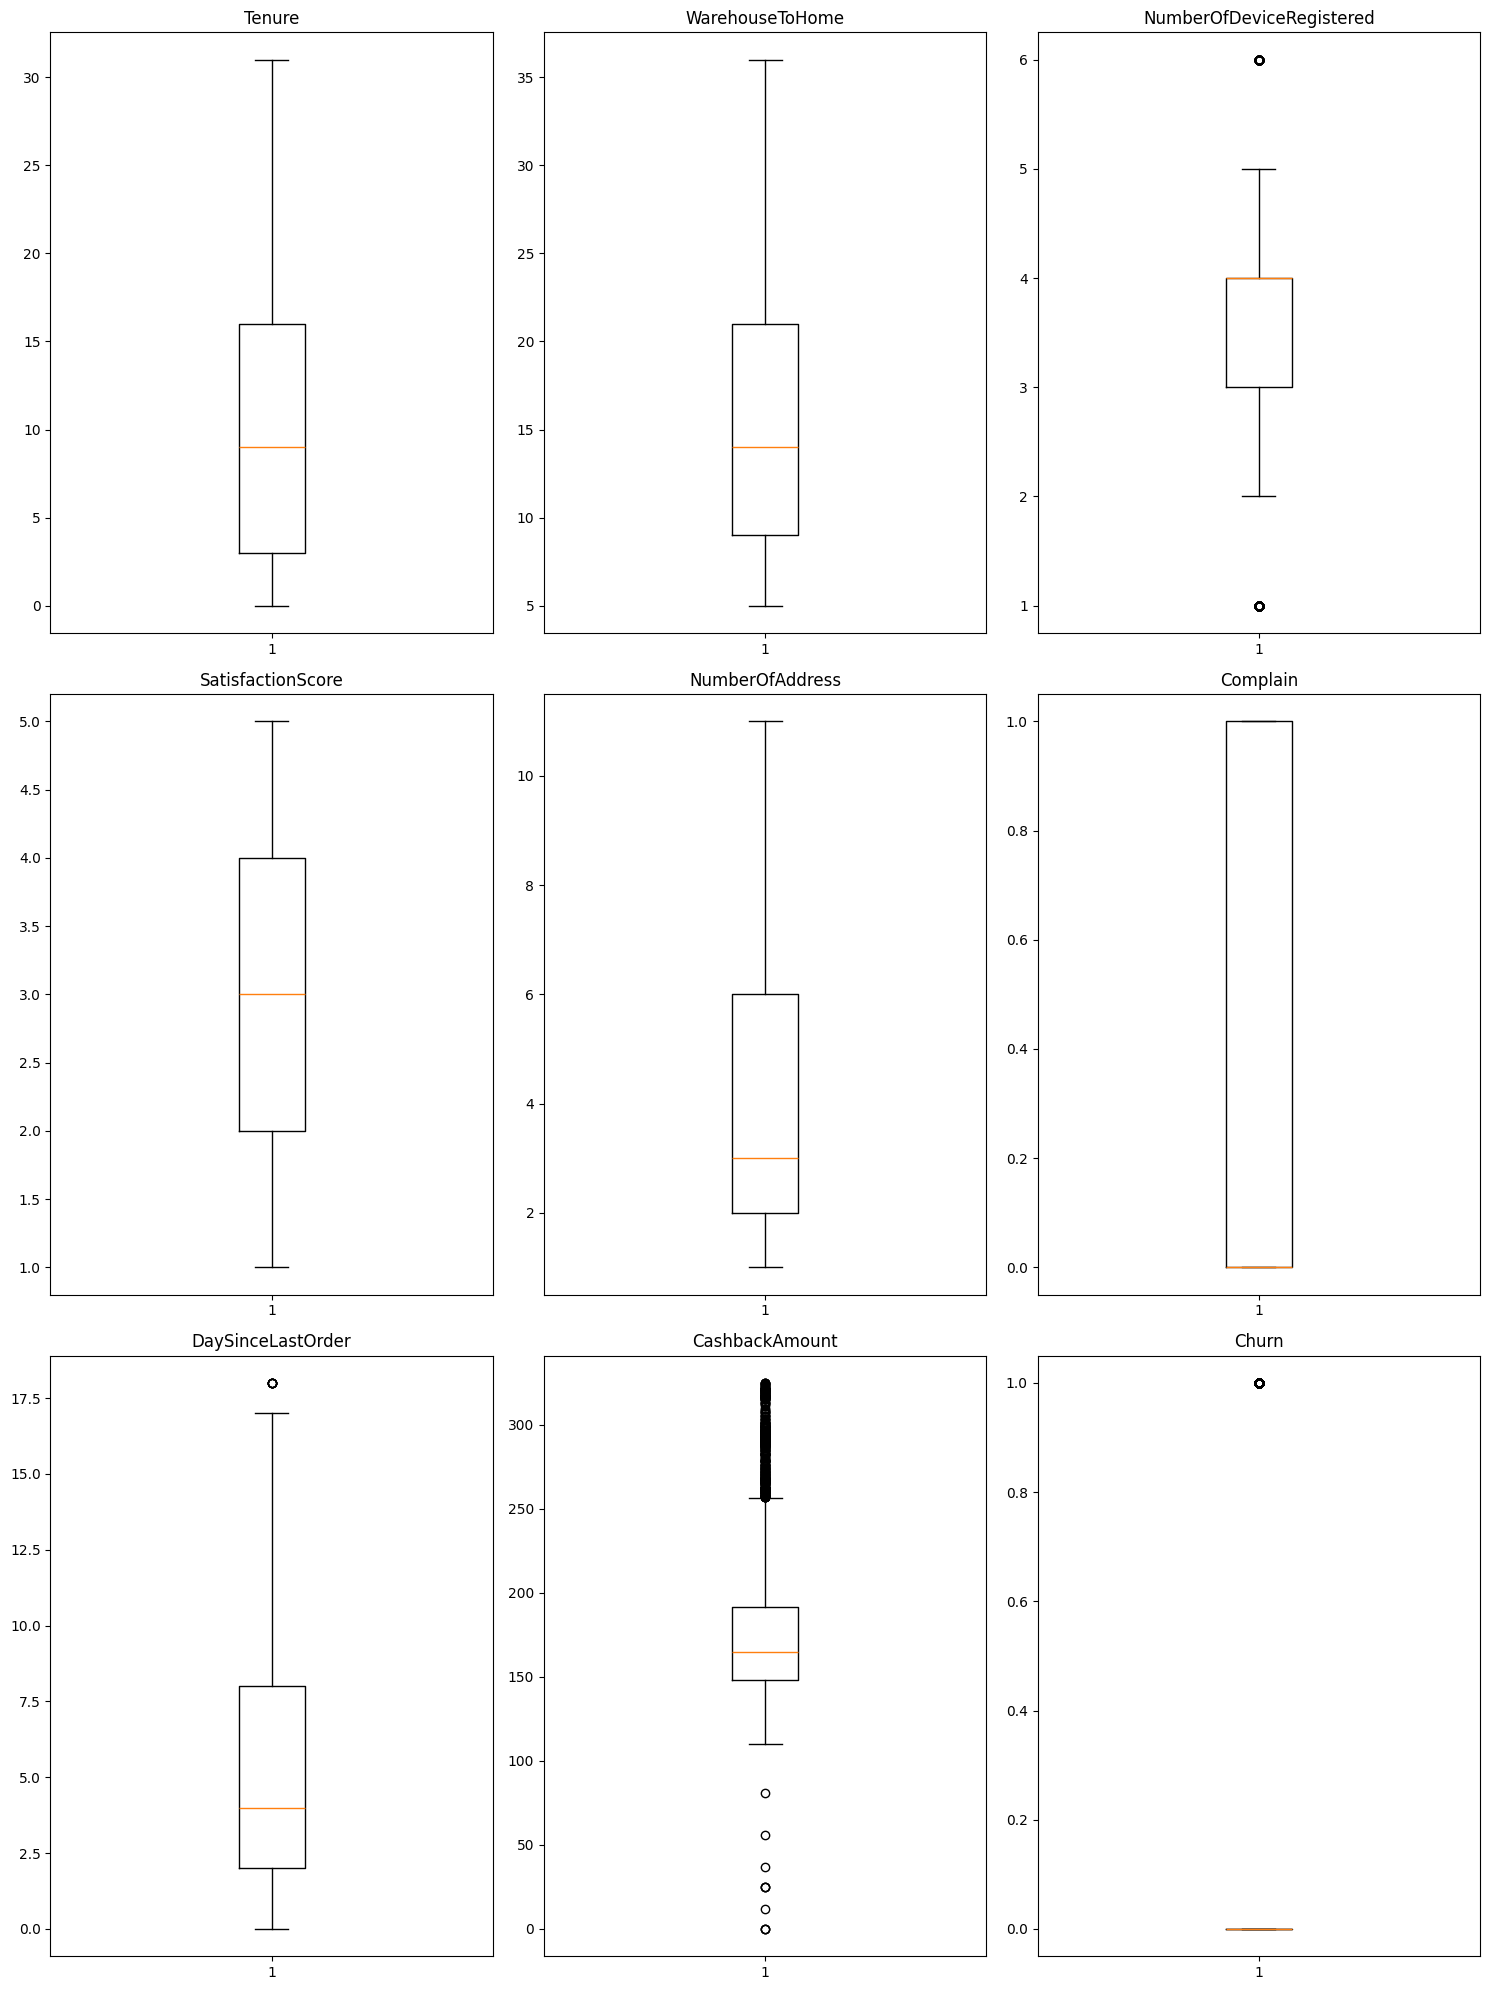

In [71]:
check_data_numerical_columns = real_data.select_dtypes(include=['float64', 'int64']).columns
subplot_cols = len(check_data_numerical_columns)
subplot_rows = (subplot_cols // 3 ) + (subplot_cols % 3 > 0 )

plt.figure(figsize=(15,20))

for i, column in enumerate(check_data_numerical_columns, 1):
    plt.subplot(subplot_rows, 3, i)
    plt.boxplot(real_data[column])
    plt.title(column)

plt.tight_layout()
plt.show()

After we took off the outliers, now the data is ready for exploratory data analysis

## **Exploratory Data Analysis**

Before we get to know which column correlate the most with our target column, let's map the categorical columns into numbers. This is also called 'Ordinal Encoding'. The reason why we are doing this is that, we are about to create Heatmap to see number of correlation between certain columns to the target column, and Heatmap doesn't understand textual categorical coluumns. Hence the mapping process.

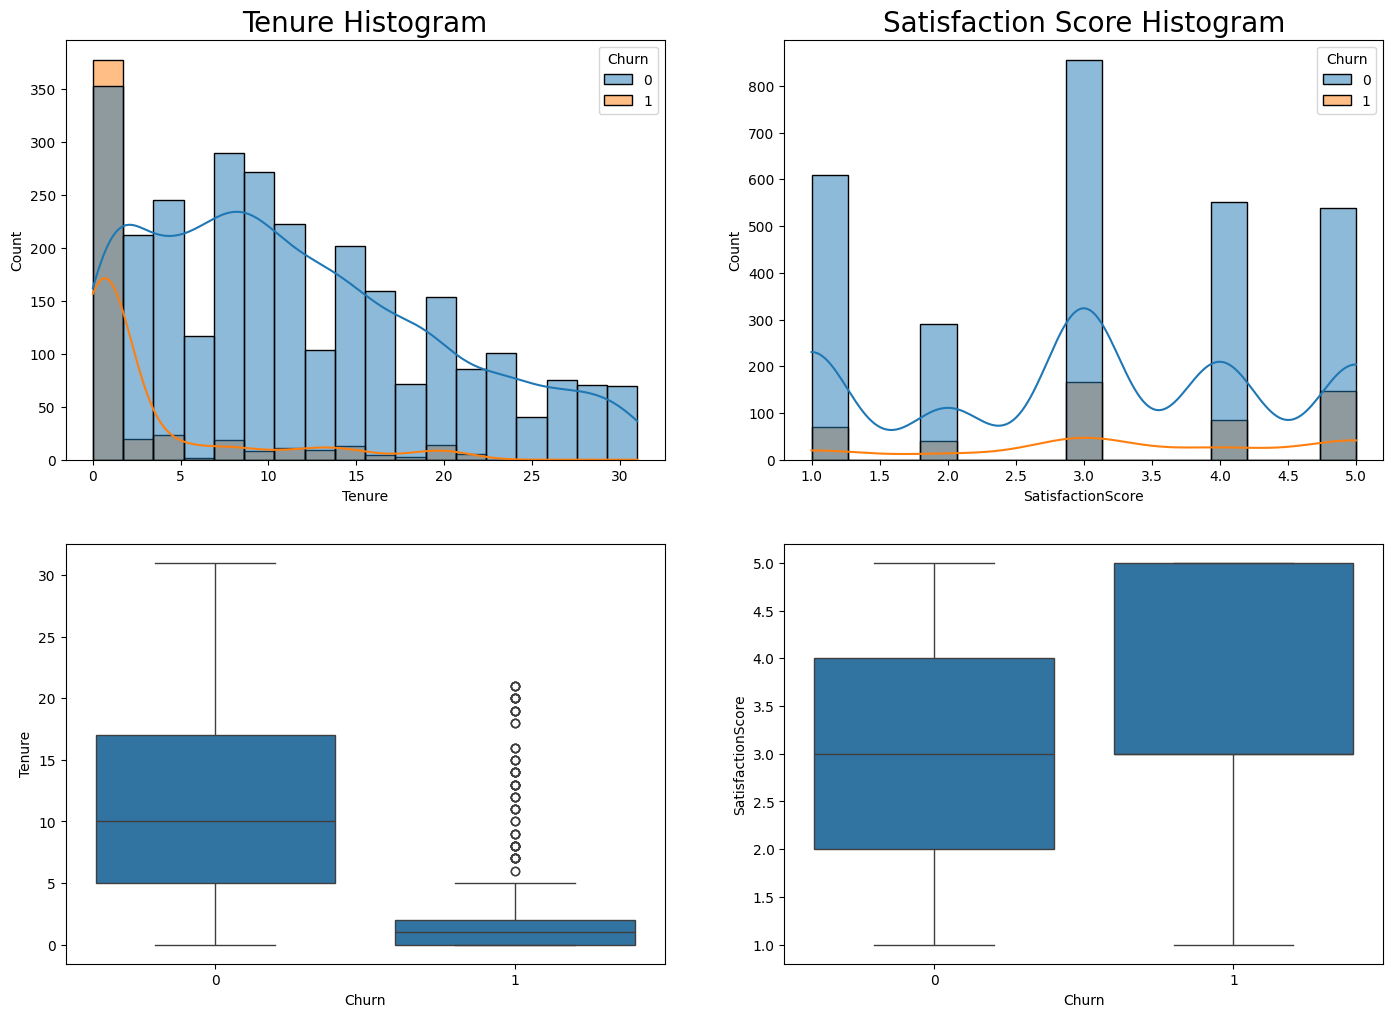

In [72]:
plt.figure(figsize=(17,12))

plt.subplot(221)
sns.histplot(data=real_data,x='Tenure',hue='Churn',kde=True)
plt.title('Tenure Histogram',fontsize=20)

plt.subplot(222)
sns.histplot(data=real_data,x='SatisfactionScore',hue='Churn',kde=True)
plt.title('Satisfaction Score Histogram',fontsize=20)

plt.subplot(223)
sns.boxplot(data=real_data,y='Tenure', x='Churn')

plt.subplot(224)
sns.boxplot(data=real_data,y='SatisfactionScore', x='Churn')
plt.show()

From the analysis above we can conclude that customers that churn are mostly those who have low-level Tenure that isn't even 5 months into the service (maybe FOMO?). And on the satisfaction score it somehow those with higher satisfaction score the one that churning, this doesn't make any sense.

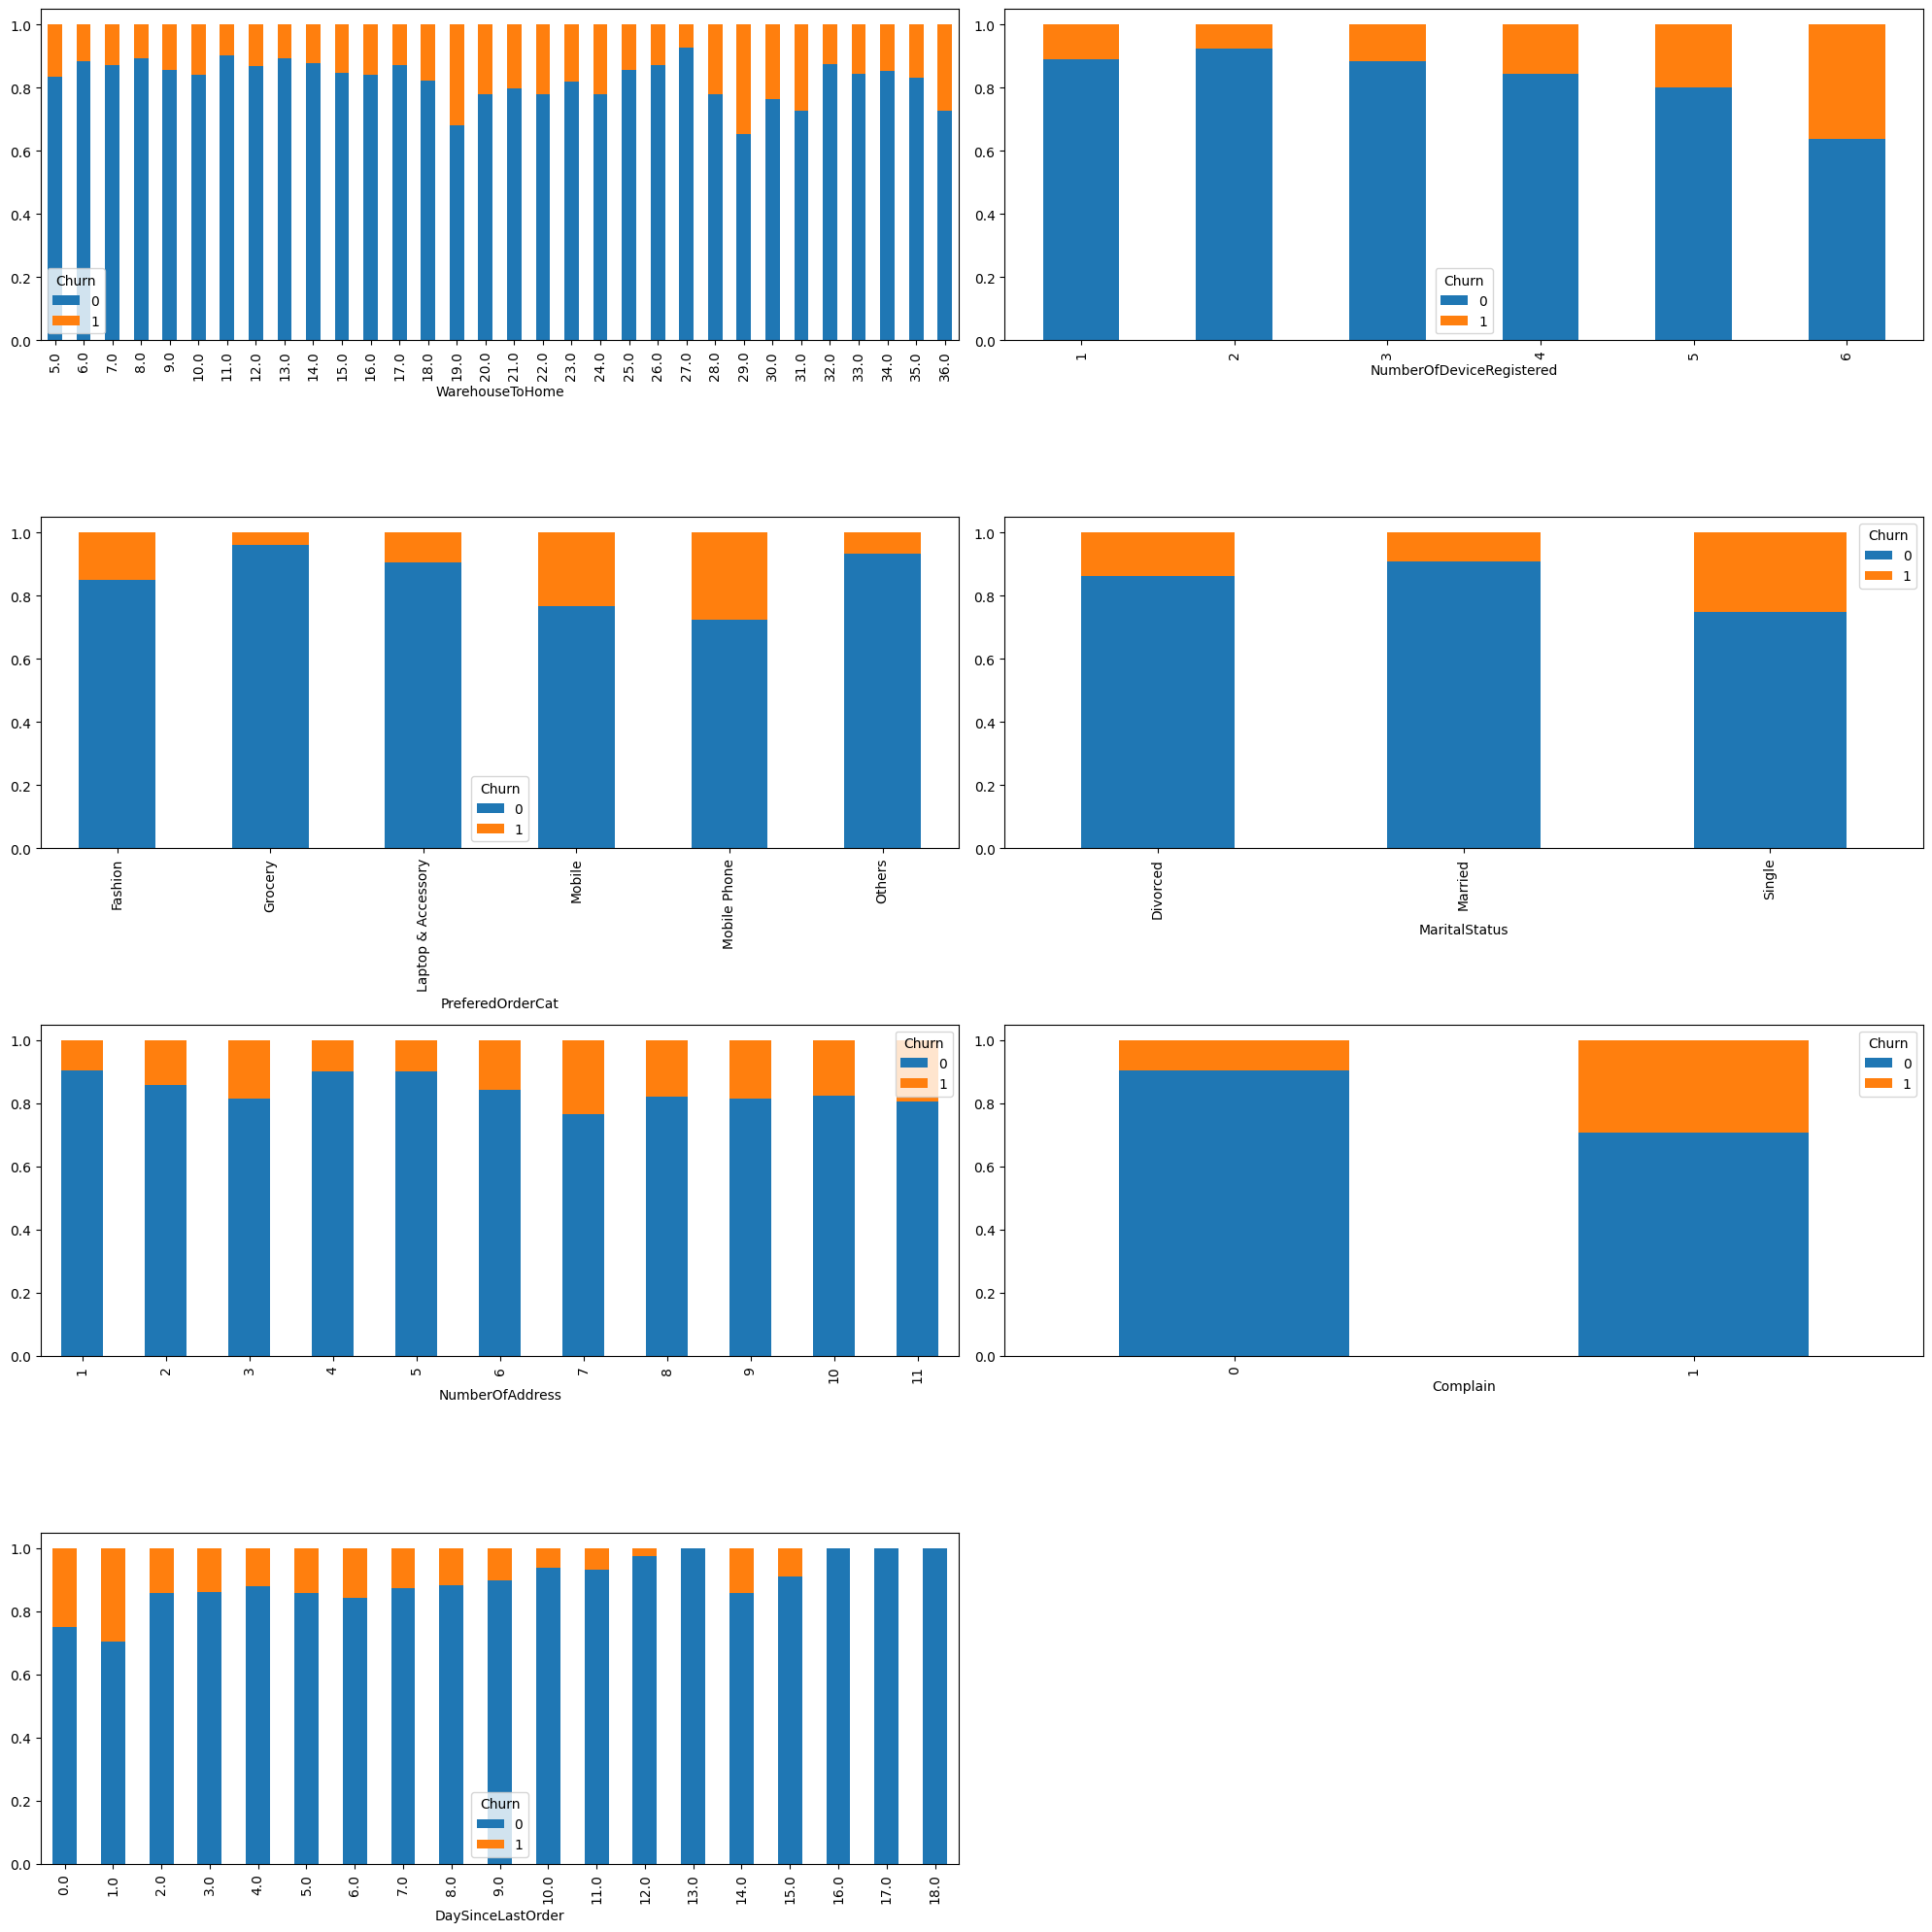

In [73]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in real_data.drop(columns=['Churn','SatisfactionScore','Tenure', 'CashbackAmount']).columns:
    count +=1
    ax= plt.subplot(4,2,count)
    pd.crosstab(real_data[i],real_data['Churn'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

In [74]:
for i in real_data.drop(columns=['Churn','SatisfactionScore','Tenure', 'CashbackAmount']).columns:
    tenure_data = real_data.groupby(i)['Churn'].value_counts(normalize=True).unstack()
    display(tenure_data.sort_values(by=[1.0], ascending=False))

Churn,0,1
WarehouseToHome,,
29.0,0.652174,0.347826
19.0,0.680000,0.320000
36.0,0.727273,0.272727
31.0,0.727273,0.272727
30.0,0.762712,0.237288
24.0,0.777778,0.222222
22.0,0.777778,0.222222
20.0,0.777778,0.222222
28.0,0.780488,0.219512


Churn,0,1
NumberOfDeviceRegistered,,
6,0.639175,0.360825
5,0.800000,0.200000
4,0.842818,0.157182
3,0.884411,0.115589
1,0.891304,0.108696
2,0.922652,0.077348


Churn,0,1
PreferedOrderCat,,
Mobile Phone,0.723529,0.276471
Mobile,0.767347,0.232653
Fashion,0.849282,0.150718
Laptop & Accessory,0.905983,0.094017
Others,0.932961,0.067039
Grocery,0.961390,0.038610


Churn,0,1
MaritalStatus,,
Single,0.749548,0.250452
Divorced,0.860656,0.139344
Married,0.906871,0.093129


Churn,0,1
NumberOfAddress,,
7,0.767606,0.232394
11,0.805970,0.194030
9,0.815789,0.184211
3,0.816302,0.183698
8,0.820225,0.179775
10,0.823077,0.176923
6,0.844444,0.155556
2,0.858090,0.141910
4,0.900000,0.100000


Churn,0,1
Complain,,
1,0.707983,0.292017
0,0.903870,0.096130


Churn,0,1
DaySinceLastOrder,,
1.0,0.703614,0.296386
0.0,0.750000,0.250000
6.0,0.842105,0.157895
14.0,0.857143,0.142857
2.0,0.857798,0.142202
5.0,0.859060,0.140940
3.0,0.861252,0.138748
7.0,0.874126,0.125874
4.0,0.878378,0.121622


Based on the table and graph above, we can conclude that `WarehouseToHome` = 29.0 churns the most, so is `NumOfDeviceRegistered` = 6, `PreferedOrderCat` = Mobile Phone, `Marital Status` = Single, `NumOfAddress` = 7, `Complain` = 1, and `DaySinceLastOrder` = 1. To make ourselves sure on which column correlates the most with `Churn` column (target), we can do heatmap plotting, but first we have to map the categorical data first.

In [75]:
edaData = real_data.copy()

In [76]:
edaData['MaritalStatus'] = edaData['MaritalStatus'].map({'Single':0
                                                   ,'Married':1
                                                   ,'Divorced':2})

edaData['PreferedOrderCat'] = edaData['PreferedOrderCat'].map({'Laptop & Accessory' : 0
                                                         ,'Mobile' : 1
                                                         ,'Fashion' : 2
                                                         ,'Others' : 3
                                                         ,'Mobile Phone' : 4
                                                         ,'Grocery' : 5
                                                         })
display(edaData.head(5), edaData.tail(5))

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,0,3,0,2,0,7.0,143.32,0
1,7.0,25.0,4,1,1,1,2,0,7.0,129.29,0
2,27.0,13.0,3,0,1,1,5,0,7.0,168.54,0
4,30.0,15.0,4,3,4,0,8,0,8.0,322.17,0
5,7.0,16.0,4,4,2,2,2,0,11.0,152.81,0


,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
3935,26.0,7.0,4,5,1,1,4,0,9.0,295.99,0
3936,28.0,9.0,5,2,3,1,8,0,1.0,231.86,0
3937,8.0,7.0,2,4,2,0,4,0,4.0,157.80,0
3938,30.0,6.0,5,0,3,1,3,1,2.0,156.60,0
3940,2.0,7.0,3,0,5,1,1,0,2.0,153.73,0


Now that we have turned our dataset into all numerical data type, we can't just yet to create a heatmap. First, we have to see if the target column is symmetrically distributed or not. The reason why we do this is because in order to create Heatmap, we have to give information to Seaborn regarding the correlation tests that we are about todo. If the target data is symmetrically distributed, then we are going to use Pearson test. However,if the target data is asymmetrically distributed, then we are going to use Spearman test. 

In [77]:
display(real_data.head(5), real_data.tail(5))

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
5,7.0,16.0,4,Mobile Phone,2,Divorced,2,0,11.0,152.81,0


,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
3935,26.0,7.0,4,Grocery,1,Married,4,0,9.0,295.99,0
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0
3940,2.0,7.0,3,Laptop & Accessory,5,Married,1,0,2.0,153.73,0


In [78]:
edaData['Churn'].value_counts()/len(edaData) * 100

Churn
0    84.828614
1    15.171386
Name: count, dtype: float64

Now we know that our target column has imbalance where 85% is negative churn, and 15% is positive churn. Hence the imbalance, we are going to use spearman test for the heatmap method.

Text(0.5, 1.0, 'Heatmap Correlation')

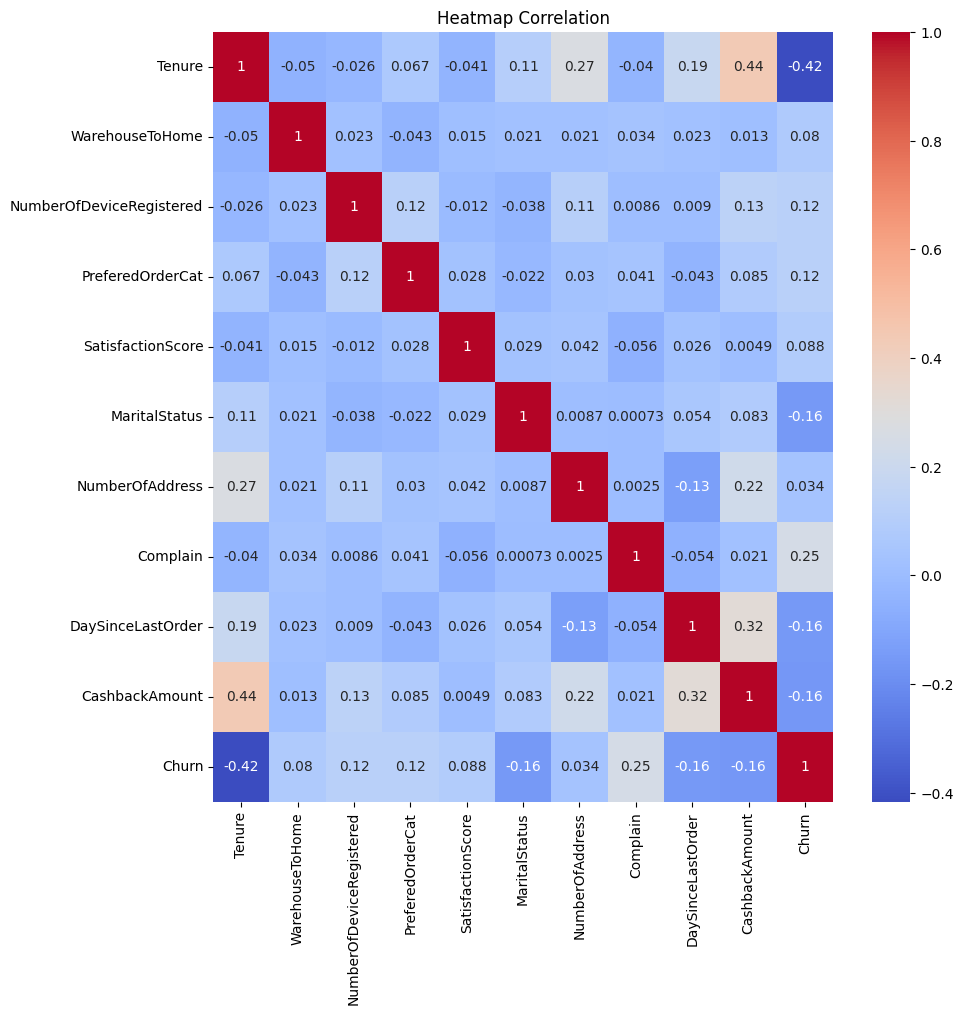

In [79]:
plt.figure(figsize=(10,10))
sns.heatmap(edaData.corr('spearman'), annot=True, cmap='coolwarm')
plt.title ('Heatmap Correlation')

As we can see in the heatmap above, not all the columns has significance correlation to target column, only a few of them, and in here we are going to sort them from the most significance to least significance correlation to Target variable (Churn):

1. Tenure
2. Complain
3. CashBackAmount
4. DaySinceLastOrder
5. MaritalStatus
7. PreferedOrderCat
8. NumberOfDeviceRegistered

## **Feature Selection**

As we already did the correlation test, `Tenure`, `Complain`, `CashBackAmount`, `DaySinceLastOrder`, `MaritalStatus`, `PreferedOrderCat`, and `NumberOfDeviceRegistiered` will be our predictor features, while `Churn` will be our label feature. We will split training and testing data into 80% training data and 20% testing data.

In [80]:
X = real_data[['Tenure', 'Complain', 'DaySinceLastOrder', 'CashbackAmount', 'MaritalStatus', 'PreferedOrderCat', 'NumberOfDeviceRegistered']]
Y = real_data['Churn']

xtrain, xtest, ytrain, ytest = train_test_split(X
                                                ,Y
                                                ,random_state = 69
                                                ,test_size = 0.2
                                                ,stratify = Y)

Since we are doing classification, we are using 'Stratify' function during train-stest splitting to balance the ratio of 1 and 0s both in testing target and training target. We can testify by seeing the value count of ytrain and ytest

In [81]:
ytrain.value_counts()

Churn
0    2277
1     407
Name: count, dtype: int64

In [82]:
ytest.value_counts()

Churn
0    569
1    102
Name: count, dtype: int64

As we can see above both testing and training target has the same 1:0 ratio of 1/5. This makes the target feature to be stratified.

## **Pre-Processing**

After we select our predictor and target features, we preprocess the predictor according to their data type. For numerical data, we preprocess it using standard scaler, for categorical data we are using OneHotEncoder. Why? because our categorical data aren't really that much uniquely. `PreferedOrderCat` only has 6 unique data, and `MaritalStatus` only has 3 unique data, so it is best to use OneHotEncoder.

In [83]:
extract_item = []
for column_names in X.columns:
    extract_item.append([
        column_names
        ,X[column_names].dtype
        ,X[column_names].isna().sum()
        ,round(X[column_names].isna().sum()/len(X)*100, 2)
        ,X[column_names].nunique()
        ,X[column_names].unique()[:3]
    ])

extracted_item = pd.DataFrame(extract_item, columns='Name, Data Type, Miss Val (Num), Miss Val (%), Unique (Num), Sample of Unique'.split(', '))
extracted_item[(extracted_item['Data Type'] == 'object')]

,Name,Data Type,Miss Val (Num),Miss Val (%),Unique (Num),Sample of Unique
4,MaritalStatus,object,0,0.0,3,"[Single, Married, Divorced]"
5,PreferedOrderCat,object,0,0.0,6,"[Laptop & Accessory, Mobile, Others]"


In [109]:
numerical_StdScaler = X.select_dtypes(include=['float64', 'int64']).columns
categorical_OHE = X.select_dtypes(include=['object']).columns

prepros = ColumnTransformer([
    ('Numerical', StandardScaler(), numerical_StdScaler)
    ,('OneHot Categorical', OneHotEncoder(), categorical_OHE)
],remainder='passthrough')

prepros

ColumnTransformer(remainder='passthrough',
                  transformers=[('Numerical', StandardScaler(),
                                 Index(['Tenure', 'Complain', 'DaySinceLastOrder', 'CashbackAmount',
       'NumberOfDeviceRegistered'],
      dtype='object')),
                                ('OneHot Categorical', OneHotEncoder(),
                                 Index(['MaritalStatus', 'PreferedOrderCat'], dtype='object'))])

## **Model Benchmarking**

After we define preprocessing methods for our features according to their data types, now we prepare algorithms, or Machine Learning models, that we will use as a basis of our churn detection model. In here we are using:

- K Nearest Neighbour (KNN)
- Decision Tree (DT)
- Logistic Regression (LogRes)
- Soft Voting Ensemble Method using KNN, DT, and LogRes (Soft Voting)
- Hard Voting Ensemble Method using KNN, DT, and LogRes (Hard Voting)
- Stacking Ensemble Method using KNN, DT, and LogRes with KNN as the final estimator (Stacking KNN)
- Stacking Ensemble Method using KNN, DT, and LogRes with DT as the final estimator (Stacking DT)
- Stacking Ensemble Method using KNN, DT, and LogRes with LogRes as the final estimator (Stacking LogRes)
- Bagging Ensemble using LogRes as estimator
- Random Forest
- Ada Boost
- Gradient Boosting
- XGBoost

In [85]:
# Define Model (KNN, DT, LogReg, SoftVote, HardVote, Stacking-KNN, Stacking-DT, Stacking-Logreg)

knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)
logreg = LogisticRegression()

soft = VotingClassifier([
    ('knn', knn)
    ,('dt', dt)
    ,('logreg', logreg)
], voting='soft')

hard = VotingClassifier([
    ('knn', knn)
    ,('dt', dt)
    ,('logreg', logreg)
], voting='hard')

stck_knn = StackingClassifier([
    ('knn', knn)
    ,('dt', dt)
    ,('logreg', logreg)
], final_estimator=knn)

stck_dt = StackingClassifier([
    ('knn', knn)
    ,('dt', dt)
    ,('logreg', logreg)
], final_estimator=dt)

stck_logreg = StackingClassifier([
    ('knn', knn)
    ,('dt', dt)
    ,('logreg', logreg)
], final_estimator=logreg)

bag_mod = BaggingClassifier(estimator=logreg, n_estimators=250)
ranFor_mod = RandomForestClassifier(n_estimators=250)
adaboost_mod = AdaBoostClassifier(n_estimators=250)
gb_mod = GradientBoostingClassifier(n_estimators=250)
xgb_mod = XGBClassifier()

RealModels = [knn, dt, logreg, soft, hard, stck_knn, stck_dt, stck_logreg, bag_mod, ranFor_mod, adaboost_mod, gb_mod, xgb_mod]
RealModelNames = 'KNN, Decision Tree, LogReg, Soft Voting, Hard Voting, Stacking-KNN, Stacking-DT, Stacking-Logreg, Bagging-Logreg, Random Forest, Ada Boost, GradientBoosting, XGBoost'.split(', ')

All those algorithms or models are encapsulated into one pipeline. where then each algorithms will be fitted into the training set. The result will be in a form of table, where we can easily compare one model to another.

In [86]:
RealResult = []

for RealModel, RealModelName in zip(RealModels, RealModelNames):
    RealPipe = sklPipe([
        ('preprocessing', prepros)
        ,('Model', RealModel)
    ])
    
    RealPipe.fit(xtrain, ytrain)
    RealPred = RealPipe.predict(xtest)
    
    RealResult.append({
            'Model': RealModelName
            ,'Recall Score': recall_score(ytest, RealPred)
        })


In [87]:
pd.DataFrame(RealResult).sort_values('Recall Score', ascending=False)

,Model,Recall Score
1,Decision Tree,0.696078
9,Random Forest,0.696078
12,XGBoost,0.666667
11,GradientBoosting,0.647059
3,Soft Voting,0.617647
6,Stacking-DT,0.617647
7,Stacking-Logreg,0.617647
5,Stacking-KNN,0.578431
4,Hard Voting,0.549020
10,Ada Boost,0.529412


Based on the result above, we can see that Decision tree, Random Forest, and XGBoost, are top 3 best performing models in predicting churn customer. However, this is only one-time testing. Let's evaluate the model by using Cross Validation.

Cross Validation method runs the modelling process on n different subset of the data to get multiple measures of model quality. In this case, we are going to use 10 different subset of data, which then we will determine the measure by getting the mean of the scores.


https://www.kaggle.com/code/amarsharma768/cross-val-score

In [88]:
RealResult_CV = []

for RealModel, RealModelName in zip(RealModels, RealModelNames):
    RealPipe = sklPipe([
        ('preprocessing', prepros)
        ,('Model', RealModel)
    ])
    
    cv_score = cross_val_score(RealPipe, xtrain, ytrain, cv=10, scoring='recall')
    
    RealResult_CV.append({
            'Model': RealModelName
            ,'AVG Recall Score': cv_score.mean()
        })


In [89]:
pd.DataFrame(RealResult_CV).sort_values('AVG Recall Score', ascending=False)

,Model,AVG Recall Score
1,Decision Tree,0.724573
12,XGBoost,0.699878
9,Random Forest,0.665671
7,Stacking-Logreg,0.623598
3,Soft Voting,0.621037
11,GradientBoosting,0.606585
5,Stacking-KNN,0.604268
6,Stacking-DT,0.584817
10,Ada Boost,0.569756
4,Hard Voting,0.501098


In Cross Validation, we still get the same result which is Decision Tree, XGBoost and RandomForest as the three top performing models, but there are slight differences, Some of them have an increase in average recall where:

| Models | Previous Recall | AVG CV Recall |
| --- | --- | --- |
| Decision Tree | 0.696078 | 0.724573 |
| XGBoost | 0.666667 | 0.699878 |
| Random Forest | 0.686275 | 0.675427 |
| Stacking-Logreg | 0.617647 | 0.623598 |
| Soft Voting | 0.617647 | 0.621037 |
| GradientBoosting | 0.647059 | 0.606585 |
| Stacking-KNN | 0.578431 | 0.604268 |
| Stacking-DT | 0.617647 | 0.584817 |
| Ada Boost | 0.529412 | 0.569756 |
| Hard Voting | 0.549020 | 0.501098 |
| KNN | 0.509804 | 0.434695 |
| Bagging-Logreg | 0.441176 | 0.412317 |
| LogReg | 0.441176 | 0.409878 |



Hence we can conclude that 3 Methods: Decision Tree, XGBoost, and Random Forest, are the top three best performing algorithm. But, can we pump up the numbers to be better? Remember that we have imbalance data, where 85% of the target data is negative, while the rest is positive. This is imbalance, and to solve this imbalance, let's use Oversampling and Undersampling.

## **OverSampling & UnderSampling**

Oversampling and Undersampling is basically a method to balance the classification data in order to reach better result.

**1. Oversampling**

Oversampling balance the data by increasing the number of smaller data to be as much as the bigger data. This is done by generating random samples based on the bigger data.

**2. Undersampling**

Undersampling balance the data by decreasing the number of bigger data to be as small as the smaller data. This is done by eliminating some data in the bigger one until the bigger data is as much as the smaller data. 

In [90]:
OverSampModels = [dt, xgb_mod, ranFor_mod]
OverSampModelsNames = ['Decision Tree', 'XGBoost', 'Random Forest']

UnderSampModels = OverSampModels
UnderSampModelsNames = OverSampModelsNames
OverSampModels

[DecisionTreeClassifier(random_state=42),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...),
 RandomForestClassifier(n_estimators=250)]

With best three models, we are doing oversampling and undersampling.

In oversampler, we are using:

- Random Over Sampler
- ADASYN
- SMOTE
- Borderline SMOTE
- KMeans SMOTE
- SVM SMOTE

While undersampler, we are using:

- Random Under Sampler
- Near Miss
- Condensed Nearest Neighbour
- Cluster Centroids
- Tome K Links

In [91]:
#OverSampler
ros = RandomOverSampler(random_state=69)
adasyn = ADASYN(random_state=69)
smote = SMOTE(random_state=69)
bsmote = BorderlineSMOTE(random_state=69)
kmsmote = KMeansSMOTE(random_state=69)
svm = SVMSMOTE(random_state=69)

OverSampAlgos = [ros, adasyn, smote, bsmote, svm]

#undersampler
rus = RandomUnderSampler()
nm = NearMiss()
cnn = CondensedNearestNeighbour()
cc = ClusterCentroids()
tkl = TomekLinks()

UnderSampAlgos = [rus, nm, cnn, cc, tkl]


To apply the imbalance classification treatment, we encapsulate the model, the training and testing data, as well as the resampling methods, be it undersampler or oversampler in a pipeline. The output of the pipeline will be a tabular data where we can easily benchmark each resampling methods.

In [92]:
OverSampResult = []

for i, OSName in zip(OverSampModels, OverSampModelsNames) :
    for j in OverSampAlgos:
        OverSampModel = i
        OverSampAlgo = j
        OverSampPipe = ImbPipe([
            ('prepros', prepros),
            ('resamp', OverSampAlgo),
            ('model', OverSampModel)
        ])
        
        OverSampPipe.fit(xtrain, ytrain)
        resamp_pred = OverSampPipe.predict(xtest)
        
        OverSampResult.append({
            'Model': OSName
            ,'OverSampler' : OverSampAlgo
            ,'Recall Score': recall_score(ytest, resamp_pred)
        })

In [93]:
pd.DataFrame(OverSampResult).sort_values('Recall Score', ascending=False)

,Model,OverSampler,Recall Score
5,XGBoost,RandomOverSampler(random_state=69),0.764706
8,XGBoost,BorderlineSMOTE(random_state=69),0.764706
2,Decision Tree,SMOTE(random_state=69),0.754902
7,XGBoost,SMOTE(random_state=69),0.754902
0,Decision Tree,RandomOverSampler(random_state=69),0.735294
4,Decision Tree,SVMSMOTE(random_state=69),0.735294
6,XGBoost,ADASYN(random_state=69),0.725490
3,Decision Tree,BorderlineSMOTE(random_state=69),0.715686
9,XGBoost,SVMSMOTE(random_state=69),0.715686
10,Random Forest,RandomOverSampler(random_state=69),0.715686


Here we can see that with oversampling treatment, we can get up to 76% of recall score using Random Over Sampler, on XGBoost while Decision Tree can only reach up to 75% recall score using SMOTE, and RandomForest can only get up to 71% recall score. This looks okay, but this is only tested once. How about we do a cross validation to evaluate this model that is equipped with oversampler?

In [94]:
OverSampResult_CV = []

for i, OSName in zip(OverSampModels, OverSampModelsNames) :
    for j in OverSampAlgos:
        OverSampModel = i
        OverSampAlgo = j
        OverSampPipe = ImbPipe([
            ('prepros', prepros),
            ('resamp', OverSampAlgo),
            ('model', OverSampModel)
        ])
        
        #cv_results = cross_validate(OverSampPipe, xtrain, ytrain, cv=10, scoring=recall_score(), return_train_score=True)
        cv_score = cross_val_score(OverSampPipe, xtrain, ytrain, cv=10, scoring='recall')
        
        OverSampResult_CV.append({
            'Model': OSName
            ,'OverSampler' : OverSampAlgo
            ,'AVG Recall Score': cv_score.mean()
        })

In [95]:
pd.DataFrame(OverSampResult_CV).sort_values('AVG Recall Score', ascending=False)

,Model,OverSampler,AVG Recall Score
5,XGBoost,RandomOverSampler(random_state=69),0.773659
6,XGBoost,ADASYN(random_state=69),0.763841
8,XGBoost,BorderlineSMOTE(random_state=69),0.756402
9,XGBoost,SVMSMOTE(random_state=69),0.756280
7,XGBoost,SMOTE(random_state=69),0.746707
11,Random Forest,ADASYN(random_state=69),0.739146
14,Random Forest,SVMSMOTE(random_state=69),0.736768
2,Decision Tree,SMOTE(random_state=69),0.734268
12,Random Forest,SMOTE(random_state=69),0.729451
13,Random Forest,BorderlineSMOTE(random_state=69),0.729451


We can see that XGBoost with Random Over Sampler thriving with the number of Recall score pumped up to 77%. Not only that, but top 5 best performing model is all XGBoost in Oversampling after we do 10 Cross Validation. How about the Undersampling?

In [96]:
UnderSampResult = []

for i, USName in zip(UnderSampModels, UnderSampModelsNames) :
    for j in UnderSampAlgos:
        UnderSampModel = i
        UnderSampAlgo = j
        UnderSampPipe = ImbPipe([
            ('prepros', prepros),
            ('resamp', UnderSampAlgo),
            ('model', UnderSampModel)
        ])
        
        UnderSampPipe.fit(xtrain, ytrain)
        UnderSampPred = UnderSampPipe.predict(xtest)
        
        UnderSampResult.append({
            'Model': USName
            ,'UnderSampler' : UnderSampAlgo
            ,'Recall Score': recall_score(ytest, UnderSampPred)
        })

In [97]:
pd.DataFrame(UnderSampResult).sort_values('Recall Score', ascending=False)

,Model,UnderSampler,Recall Score
8,XGBoost,ClusterCentroids(),0.931373
3,Decision Tree,ClusterCentroids(),0.892157
0,Decision Tree,RandomUnderSampler(),0.852941
5,XGBoost,RandomUnderSampler(),0.852941
10,Random Forest,RandomUnderSampler(),0.852941
13,Random Forest,ClusterCentroids(),0.852941
11,Random Forest,NearMiss(),0.843137
6,XGBoost,NearMiss(),0.823529
1,Decision Tree,NearMiss(),0.774510
12,Random Forest,CondensedNearestNeighbour(),0.754902


Amazingly undersampling could boost the number of recall score, as we can see that XGBoost with ClusterCentroids undersampler reaches 93% being the one and only model that reach 90-s percent. But we can't trust this, since this is just one time predicting, how about we cross validate 10 folds? What the score would be?

In [100]:
UnderSampResult_CV = []

for i, USName in zip(UnderSampModels, UnderSampModelsNames) :
    for j in UnderSampAlgos:
        UnderSampModel = i
        UnderSampAlgo = j
        UnderSampPipe = ImbPipe([
            ('prepros', prepros),
            ('resamp', UnderSampAlgo),
            ('model', UnderSampModel)
        ])
        
        cv_score = cross_val_score(UnderSampPipe, xtrain, ytrain, cv = 10, scoring='recall')
        
        UnderSampResult_CV.append({
            'Model': USName
            ,'UnderSampler' : UnderSampAlgo
            ,'Recall Score': cv_score.mean()
        })

In [101]:
pd.DataFrame(UnderSampResult_CV).sort_values('Recall Score', ascending=False)

,Model,UnderSampler,Recall Score
8,XGBoost,ClusterCentroids(),0.933537
13,Random Forest,ClusterCentroids(),0.901829
3,Decision Tree,ClusterCentroids(),0.901585
10,Random Forest,RandomUnderSampler(),0.869512
5,XGBoost,RandomUnderSampler(),0.859695
6,XGBoost,NearMiss(),0.852134
11,Random Forest,NearMiss(),0.847439
0,Decision Tree,RandomUnderSampler(),0.832866
1,Decision Tree,NearMiss(),0.810427
7,XGBoost,CondensedNearestNeighbour(),0.795854


XGBoost with Cluster Centroid undersampler has highest Recall Score of them all, let's tune it a little bit with hyperparameter tuning

## **HyperParameter Tuning**

In [114]:
HP_estimator=ImbPipe([
    ('preprocess',prepros),
    ('resamp',cc),
    ('model',xgb_mod)
])

HP_estimator

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Numerical', StandardScaler(),
                                                  Index(['Tenure', 'Complain', 'DaySinceLastOrder', 'CashbackAmount',
       'NumberOfDeviceRegistered'],
      dtype='object')),
                                                 ('OneHot Categorical',
                                                  OneHotEncoder(),
                                                  Index(['MaritalStatus', 'PreferedOrderCat'], dtype='object'))])),
                ('resamp', ClusterCentroid...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

The Hyperparameter that we are going to use are the booster, eta (learning rate), and max_depth

In [115]:
hyperparam_space=[{
    'model__booster': ['gbtree', 'gblinear'],
    'model__eta':np.arange(0.1, 0.3, 0.1),
    'model__max_depth': [1, 3, 6],
    'model__random_state': [42]
}]

Using GridSearch with 5 folds

In [116]:
grid = GridSearchCV(HP_estimator, n_jobs=-1, param_grid=hyperparam_space, scoring='recall', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))

In [117]:
grid.fit(xtrain,ytrain)
print(grid.best_score_)
print(grid.best_params_)

0.9436013249021379
{'model__booster': 'gbtree', 'model__eta': 0.1, 'model__max_depth': 6, 'model__random_state': 42}


In here we can see that we increase a little bit our model's recall score to 94%, let's save this as our best model

In [118]:
best_model = grid.best_estimator_
best_model.fit(xtrain, ytrain)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Numerical', StandardScaler(),
                                                  Index(['Tenure', 'Complain', 'DaySinceLastOrder', 'CashbackAmount',
       'NumberOfDeviceRegistered'],
      dtype='object')),
                                                 ('OneHot Categorical',
                                                  OneHotEncoder(),
                                                  Index(['MaritalStatus', 'PreferedOrderCat'], dtype='object'))])),
                ('resamp', ClusterCentroid...
                               eval_metric=None, feature_types=None, gamma=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

let's compare it to our previous model

In [124]:
XGB_estimator=ImbPipe([
    ('preprocess',prepros),
    ('resamp',cc),
    ('model',xgb_mod)
])
XGB_estimator.fit(xtrain, ytrain)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Numerical', StandardScaler(),
                                                  Index(['Tenure', 'Complain', 'DaySinceLastOrder', 'CashbackAmount',
       'NumberOfDeviceRegistered'],
      dtype='object')),
                                                 ('OneHot Categorical',
                                                  OneHotEncoder(),
                                                  Index(['MaritalStatus', 'PreferedOrderCat'], dtype='object'))])),
                ('resamp', ClusterCentroid...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [127]:
DefaultPred = XGB_estimator.predict(xtest)
HPPred = best_model.predict(xtest)

recall_default = recall_score(ytest, DefaultPred)
recall_tuned = recall_score(ytest, HPPred)

print('Recall Score Default XGBoost: ', recall_default)
print('Recall Score Tuned XGBoost : ', recall_tuned)

Recall Score Default XGBoost:  0.9313725490196079
Recall Score Tuned XGBoost :  0.9411764705882353


In [129]:
report_default = classification_report(ytest, DefaultPred)
report_tuned = classification_report(ytest, HPPred)

print('Classification Report Default XGBoost : \n', report_default)
print('Classification Report Tuned XGBoost : \n', report_tuned)

Classification Report Default XGBoost : 
               precision    recall  f1-score   support

           0       0.98      0.63      0.76       569
           1       0.31      0.93      0.46       102

    accuracy                           0.67       671
   macro avg       0.64      0.78      0.61       671
weighted avg       0.88      0.67      0.72       671

Classification Report Tuned XGBoost : 
               precision    recall  f1-score   support

           0       0.98      0.60      0.75       569
           1       0.30      0.94      0.45       102

    accuracy                           0.65       671
   macro avg       0.64      0.77      0.60       671
weighted avg       0.88      0.65      0.70       671



## **Conclusion**

Based on our classification report, we can conclude that if we are about to use this model, we can detect 93% from our customers that is about to churn. This model is also has a precision of 31%.

If for example for every 4% of our customer churns in a month, we could lost 8 million USD in revenue (based on Netflix's case in this link https://clevertap.com/blog/impact-of-customer-churn/)
and for example if we have 100 million Customers, and 4 million of them churning it could be a total disaster for Copi. But if we can detect 93% correctly whether the customer is about to churn or not, we can retain our company's revenue.

Let's take a look at below simulation

Without Our Model

- Lost Customers due to churning -> 4% * 100 millions = 4 millions
- If each customer could generate 2 USD in Copi
- Lost revenue due to churning -> 2 * 4 Million USD = 8 million USD

With our model

- Lost Customers due to churning -> 4% * 100 millions = 4 millions
- Customers retain with our model -> 93% * 4 million = 3.72 millions
- If each customer could generate 2 USD in Copi
- Lost revenue due to churning -> 2 * 4 Million USD = 8 million USD
- Revenue retained with our model -> 93% * 8 Million USD = 7.44 Million USD
- Amount of revenue retained -> 8 - 7.44 = 560.000 USD

From the calculation above, our model can save quite a number of revenue

## **Recommendation**

Our recommendation on this:
- Generate promos for the customers, especially for the singles, as we can see in the heatmap, feature of `MaritalStatus` is quite correlates to churns
- Create a policy that restrain customer to take tenure less than 5 months

In [122]:
import pickle

with open('best_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

print("Model saved successfully.")

Model saved successfully.
